# Stock Market Prediction Model of the Magnificient Seven 

#pip install the dependencies from requirements. May take up to 12 minutes

In [1]:
!python3 -m pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


### importing our libraries after pipinstall

In [2]:

#python data manipulation
import pandas as pd
import numpy as np

#data visualizaiton tools, EDA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#mysql and Cassandra
import mysql.connector                         
from cassandra.cluster import Cluster          

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

#LSTM Neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# our finance data
import yfinance as yf



/Users/amara/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Extracting the Historical Data.


 ### The historical aspect of the data is starting from January 1st 2020 to yesterday (april 6th), We can adjust this to most recent always. We extracted the 7 companies and start with first 7 features from our project proposal: Date/time, open price, low price, high price, adjusted close price, trading volume

In [3]:
def extract_data(tickers, start_date="2020-01-01", end_date="2025-04-06", interval="1d"):
    # importing the yfinance api data, making sure the autoadjust is off because it overrides the close value if its on
    df = yf.download(tickers, start=start_date, end=end_date, interval=interval, auto_adjust=False)
    # tidying the data to make it better for analysis and transformation later
    df.columns = df.columns.swaplevel(0, 1)
    df = df.sort_index(axis=1, level=0)
    df_flat = df.stack(level=0, future_stack=True).reset_index()  
    df_flat.rename(columns={'level_0': 'Date'}, inplace=True)
    # renaming 'Adj Close' to 'Adj_Close' for consistency
    if 'Adj Close' in df_flat.columns:
        df_flat.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
    # adding the previous day's close price per ticker
    df_flat['Previous_Close'] = df_flat.groupby('Ticker')['Close'].shift(1)
    # selecting the columns we expect and need
    expected_cols = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Previous_Close', 'Volume']
    existing_cols = [col for col in expected_cols if col in df_flat.columns]
    return df_flat[existing_cols]


In [4]:
#giving yfinance a list of companies to return a list of data of. AND displaying the df
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]
df_raw = extract_data(tickers)
display(df_raw)

[*********************100%***********************]  7 of 7 completed


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume
0,2020-01-02,AAPL,74.059998,75.150002,73.797501,75.087502,72.716072,NaN,135480400
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,94.900497,NaN,80580000
2,2020-01-02,GOOGL,67.420502,68.433998,67.324501,68.433998,68.108376,NaN,27278000
3,2020-01-02,META,206.750000,209.789993,206.270004,209.779999,208.795929,NaN,12077100
4,2020-01-02,MSFT,158.779999,160.729996,158.330002,160.619995,153.323288,NaN,22622100
...,...,...,...,...,...,...,...,...,...
9249,2025-04-04,GOOGL,148.009995,151.070007,145.380005,145.600006,145.600006,150.720001,62259500
9250,2025-04-04,META,506.619995,518.000000,494.200012,504.730011,504.730011,531.619995,38589800
9251,2025-04-04,MSFT,364.130005,374.589996,359.480011,359.839996,359.839996,373.109985,49209900
9252,2025-04-04,NVDA,98.910004,100.129997,92.110001,94.309998,94.309998,101.800003,532273800


## Historical Data: Data Cleaning: 
### We will clean the data by taking care of any null values. We can use back and forward filling if there is a value missing from a float/int value. Otherwise we will drop the value if its in the date or Ticker/ or use the average of the past few days for the column. Additionally if there are are any duplicate records for a company and a speciifc date, one should be kept while rest dropped.

In [5]:
nans = df_raw.isna().sum()
print(nans)
def cleaning(df):
    # Step 1: Drop duplicates (keep the first entry for each Ticker-Date pair)
    df = df.drop_duplicates(subset=['Date', 'Ticker'], keep='first')

    # Step 2: Define numeric columns to clean (excluding 'Date' and 'Ticker')
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Previous_Close']
    
    # Step 3: Fill missing values for numeric columns
    for col in numeric_cols:
        # Forward fill and backward fill first
        df[col] = df.groupby('Ticker')[col].transform(lambda x: x.ffill().bfill())
        
        # Fill remaining NaNs with rolling mean (3-day window)
        df[col] = df.groupby('Ticker')[col].transform(
            lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean())
        )

    # Step 4: Ensure 'Previous_Close' is properly filled (first entry has no previous data)
    df['Previous_Close'] = df.groupby('Ticker')['Previous_Close'].ffill()

    # Step 5: Drop rows with nulls in 'Date' or 'Ticker' (shouldn't exist, but safety check)
    df = df.dropna(subset=['Date', 'Ticker'])

    return df
# Apply cleaning
df_cleaned = cleaning(df_raw)

# Verify results
print("Null values after cleaning:")
print(df_cleaned.isna().sum())
display(df_cleaned)

Price
Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj_Close         0
Previous_Close    7
Volume            0
dtype: int64
Null values after cleaning:
Price
Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj_Close         0
Previous_Close    0
Volume            0
dtype: int64


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume
0,2020-01-02,AAPL,74.059998,75.150002,73.797501,75.087502,72.716072,75.087502,135480400
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,94.900497,94.900497,80580000
2,2020-01-02,GOOGL,67.420502,68.433998,67.324501,68.433998,68.108376,68.433998,27278000
3,2020-01-02,META,206.750000,209.789993,206.270004,209.779999,208.795929,209.779999,12077100
4,2020-01-02,MSFT,158.779999,160.729996,158.330002,160.619995,153.323288,160.619995,22622100
...,...,...,...,...,...,...,...,...,...
9249,2025-04-04,GOOGL,148.009995,151.070007,145.380005,145.600006,145.600006,150.720001,62259500
9250,2025-04-04,META,506.619995,518.000000,494.200012,504.730011,504.730011,531.619995,38589800
9251,2025-04-04,MSFT,364.130005,374.589996,359.480011,359.839996,359.839996,373.109985,49209900
9252,2025-04-04,NVDA,98.910004,100.129997,92.110001,94.309998,94.309998,101.800003,532273800


## Historical Data, Feature Engineering:

### We are going to be transforming the tidy dataframe by doing some feature engineering. We will create the following fields into our table by manipulating the prexisting data from df_cleaned: 
1. Simple Moving Average (SMA)
2. Exponential Moving Average (EMA)
3. Relative Strength Index (RSI)
4. Bollinger Bands
5. MACD (Moving Average Convergence Divergence)
6. On-Balance Volume (OBV)
7. Volatility (ATR - Average True Range)


In [6]:
def transform(df):
    # Ensure data is sorted by Ticker and Date
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    
    # 1. Simple Moving Average (SMA)
    #uses 20 periods of data (NaN till 19 row)
    df['SMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
    
    # 2. Exponential Moving Average (EMA)
    df['EMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    
    # 3. Relative Strength Index (RSI)
    #uses 14 periods of data (NaN till 13 row)
    def compute_rsi(data, period=14):
        delta = data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    df['RSI_14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)
    
    # 4. Bollinger Bands
    #NaN till we get SMA values (19th row)
    df['BB_Middle'] = df['SMA_20']
    df['BB_Std'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).std())
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']
    
    # 5. MACD
    def compute_macd(data):
        ema12 = data.ewm(span=12, adjust=False).mean()
        ema26 = data.ewm(span=26, adjust=False).mean()
        return ema12 - ema26
    df['MACD'] = df.groupby('Ticker')['Close'].transform(compute_macd)
    df['MACD_Signal'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    
    # 6. OBV (Fixed)
    def compute_obv(group):
        group['OBV'] = np.sign(group['Close'].diff()).replace(0, 1) * group['Volume']
        return group['OBV'].cumsum()
    df['OBV'] = df.groupby('Ticker').apply(compute_obv).reset_index(drop=True)
    
    # 7. ATR (Fixed)
    def compute_atr(group):
        high_low = group['High'] - group['Low']
        high_close = (group['High'] - group['Close'].shift()).abs()
        low_close = (group['Low'] - group['Close'].shift()).abs()
        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        return tr.rolling(14).mean()
    df['ATR_14'] = df.groupby('Ticker').apply(compute_atr).reset_index(drop=True)
    
    # Forward fill missing values created by rolling windows
    # df = df.groupby('Ticker').ffill()
    
    return df

# Apply transformation to cleaned data
df_transformed = transform(df_cleaned)
display(df_transformed[['Date', 'Ticker', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_Upper', 'BB_Lower', 'MACD','OBV','ATR_14']].head(n=20)) #only shows APPL b/c all other tickers appear later. 
#add in 'OBV' and 'ATR_14' when fixed 

#to filter a specific ticker: 
display(df_transformed[df_transformed['Ticker'] == 'MSFT'].iloc[20:25])

#to shuffle/show random rows: 
display(df_transformed.sample(10))  # Show random rows

# count = len(df_transformed)
# print(count)


/var/folders/sq/l_71l2mn5b78l0860dcxz4q00000gn/T/ipykernel_46976/2274645152.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['OBV'] = df.groupby('Ticker').apply(compute_obv).reset_index(drop=True)
/var/folders/sq/l_71l2mn5b78l0860dcxz4q00000gn/T/ipykernel_46976/2274645152.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['ATR_14'] = df.groupby('Ticker').apply(compute_atr).reset_index(drop=True)

Price,Date,Ticker,SMA_20,EMA_20,RSI_14,BB_Upper,BB_Lower,MACD,OBV,ATR_14
0,2020-01-02,AAPL,NaN,75.087502,NaN,NaN,NaN,0.000000,NaN,NaN
1,2020-01-03,AAPL,NaN,75.017977,NaN,NaN,NaN,-0.058234,-146322800.0,NaN
2,2020-01-06,AAPL,NaN,75.011503,NaN,NaN,NaN,-0.055930,-27935600.0,NaN
3,2020-01-07,AAPL,NaN,74.972075,NaN,NaN,NaN,-0.081607,-136807600.0,NaN
4,2020-01-08,AAPL,NaN,75.050687,NaN,NaN,NaN,-0.005068,-4728400.0,NaN
5,2020-01-09,AAPL,NaN,75.275145,NaN,NaN,NaN,0.183389,165380000.0,NaN
6,2020-01-10,AAPL,NaN,75.494893,NaN,NaN,NaN,0.342911,306024800.0,NaN
7,2020-01-13,AAPL,NaN,75.851570,NaN,NaN,NaN,0.596207,427556800.0,NaN
8,2020-01-14,AAPL,NaN,76.072372,NaN,NaN,NaN,0.702507,265602400.0,NaN
9,2020-01-15,AAPL,NaN,76.240241,NaN,NaN,NaN,0.751062,143678800.0,NaN


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume,SMA_20,EMA_20,RSI_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal,OBV,ATR_14
5308,2020-01-31,MSFT,172.210007,172.399994,169.580002,170.229996,162.496704,172.779999,36142700,164.167999,165.244291,65.892017,164.167999,3.935323,172.038644,156.297353,2.175122,1.508417,68410900.0,2.845717
5309,2020-02-03,MSFT,170.429993,174.500000,170.399994,174.380005,166.458145,170.229996,30107000,164.955999,166.114359,68.389658,164.955999,4.324559,173.605117,156.306881,2.627071,1.732148,98517900.0,3.004289
5310,2020-02-04,MSFT,177.139999,180.639999,176.309998,180.119995,171.937363,174.380005,36433300,166.010499,167.448229,75.869974,166.010499,5.271194,176.552887,155.468110,3.409114,2.067541,134951200.0,3.317145
5311,2020-02-05,MSFT,184.029999,184.199997,178.410004,179.899994,171.727402,180.119995,39186300,167.126498,168.634112,74.631681,167.126498,5.734751,178.596000,155.656997,3.965426,2.447118,95764900.0,3.601431
5312,2020-02-06,MSFT,180.970001,183.820007,180.059998,183.630005,175.287949,179.899994,27751400,168.303499,170.062292,75.172992,168.303499,6.569494,181.442486,155.164511,4.653644,2.888423,123516300.0,3.662859


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume,SMA_20,EMA_20,RSI_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal,OBV,ATR_14
7910,2025-03-06,NVDA,113.529999,115.349998,110.220001,110.570000,110.559830,117.300003,321181900,128.725999,125.398023,29.406874,128.725999,8.938293,146.602585,110.849413,-4.636115,-2.501664,5.112275e+10,7.338572
7327,2022-11-04,NVDA,13.986000,14.229000,13.697000,14.156000,14.140793,13.421000,612576000,12.605550,13.051279,76.250003,12.605550,0.868765,14.343080,10.868020,0.184973,-0.041529,2.375933e+10,0.719857
2752,2020-06-08,GOOGL,71.314003,72.449997,71.223999,72.402000,72.057487,72.000999,33878000,70.394875,70.212714,70.743131,70.394875,1.486902,73.368680,67.421071,1.708674,1.824850,5.118280e+08,1.374357
1775,2021-10-19,AMZN,171.714493,172.734497,171.100006,172.207504,172.207504,172.337006,47722000,166.135676,167.151588,64.801821,166.135676,3.929061,173.993799,158.277553,-0.033013,-1.164115,2.976792e+09,2.893464
515,2022-01-18,AAPL,171.509995,172.539993,169.410004,169.800003,166.879913,173.070007,90956700,175.404501,173.631844,32.663515,175.404501,3.615101,182.634702,168.174299,0.920994,2.249628,1.652194e+09,3.614286
662,2022-08-18,AAPL,173.750000,174.899994,173.119995,174.149994,171.863327,174.550003,62290100,164.432000,165.131910,76.721707,164.432000,7.239053,178.910105,149.953895,6.458114,5.931324,1.457002e+09,3.157143
6948,2021-05-06,NVDA,14.495250,14.571250,14.218000,14.523000,14.489902,14.458500,193380000,15.163225,14.794917,29.937908,15.163225,0.483564,16.130353,14.196097,0.159847,0.334041,1.802474e+10,0.459607
8530,2022-05-17,TSLA,249.119995,254.826660,242.949997,253.869995,253.869995,241.456665,80236200,288.395168,281.867434,37.166587,288.395168,31.352703,351.100573,225.689763,-20.363757,-15.681556,1.186643e+10,21.298097
4937,2023-11-09,META,319.420013,324.179993,318.799988,320.549988,319.046326,319.779999,16103100,311.281999,311.836660,58.755139,311.281999,9.229749,329.741497,292.822501,2.505614,1.135543,6.978174e+08,9.309995
4232,2021-01-22,META,272.010010,278.470001,272.000000,274.500000,273.212341,272.869995,21954000,265.318499,265.569231,50.925412,265.318499,9.340171,283.998841,246.638157,-2.195264,-3.860268,6.416829e+08,8.296429


Prepare for Visualization

In [7]:
#handle NaNs 
df_transformed = df_transformed.dropna(subset=['SMA_20', 'RSI_14', 'ATR_14'])

#alignment 
df_transformed['Date'] = pd.to_datetime(df_transformed['Date'])
df_transformed['Ticker'] = df_transformed['Ticker'].astype('category')

#normalization 
df_transformed['Close_Normalized'] = df_transformed.groupby('Ticker')['Close'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

#outliers
# sns.boxplot(data=df_transformed, x='Ticker', y='Volume')

#time-series alignment 
df_pivoted = df_transformed.pivot(index='Date', columns='Ticker', values='Close')
df_pivoted = df_pivoted.ffill().bfill()  # Forward/backward fill missing dates


display(df_transformed[['Date', 'Ticker', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_Upper', 'BB_Lower', 'MACD','OBV','ATR_14']].head(n=20)) 

/var/folders/sq/l_71l2mn5b78l0860dcxz4q00000gn/T/ipykernel_46976/3958572245.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_transformed['Close_Normalized'] = df_transformed.groupby('Ticker')['Close'].transform(


Price,Date,Ticker,SMA_20,EMA_20,RSI_14,BB_Upper,BB_Lower,MACD,OBV,ATR_14
19,2020-01-30,AAPL,78.009125,78.395502,63.879136,82.191922,73.826328,1.239142,429028000.0,1.525000
20,2020-01-31,AAPL,78.123625,78.298550,49.368860,82.089422,74.157828,1.002945,229439600.0,1.724285
21,2020-02-03,AAPL,78.264000,78.190593,42.987505,81.848969,74.679032,0.789509,55651200.0,1.805177
22,2020-02-04,AAPL,78.502126,78.335537,54.739602,81.779752,75.224499,0.816509,192267600.0,1.904821
23,2020-02-05,AAPL,78.790376,78.528581,57.618700,81.603189,75.977562,0.880210,311094400.0,1.904106
24,2020-02-06,AAPL,79.065625,78.792764,57.529076,81.718125,76.413125,0.995073,416520000.0,1.914820
25,2020-02-07,AAPL,79.195625,78.908453,50.957282,81.759323,76.631928,0.970421,298836000.0,1.976784
26,2020-02-10,AAPL,79.335875,79.049314,53.702040,81.834067,76.837684,0.970361,408184800.0,2.060356
27,2020-02-11,AAPL,79.369000,79.130570,51.402949,81.879378,76.858622,0.920566,313861600.0,2.091963
28,2020-02-12,AAPL,79.550500,79.384801,55.375694,82.215984,76.885017,1.022430,427592000.0,2.158035


# Data Visualization

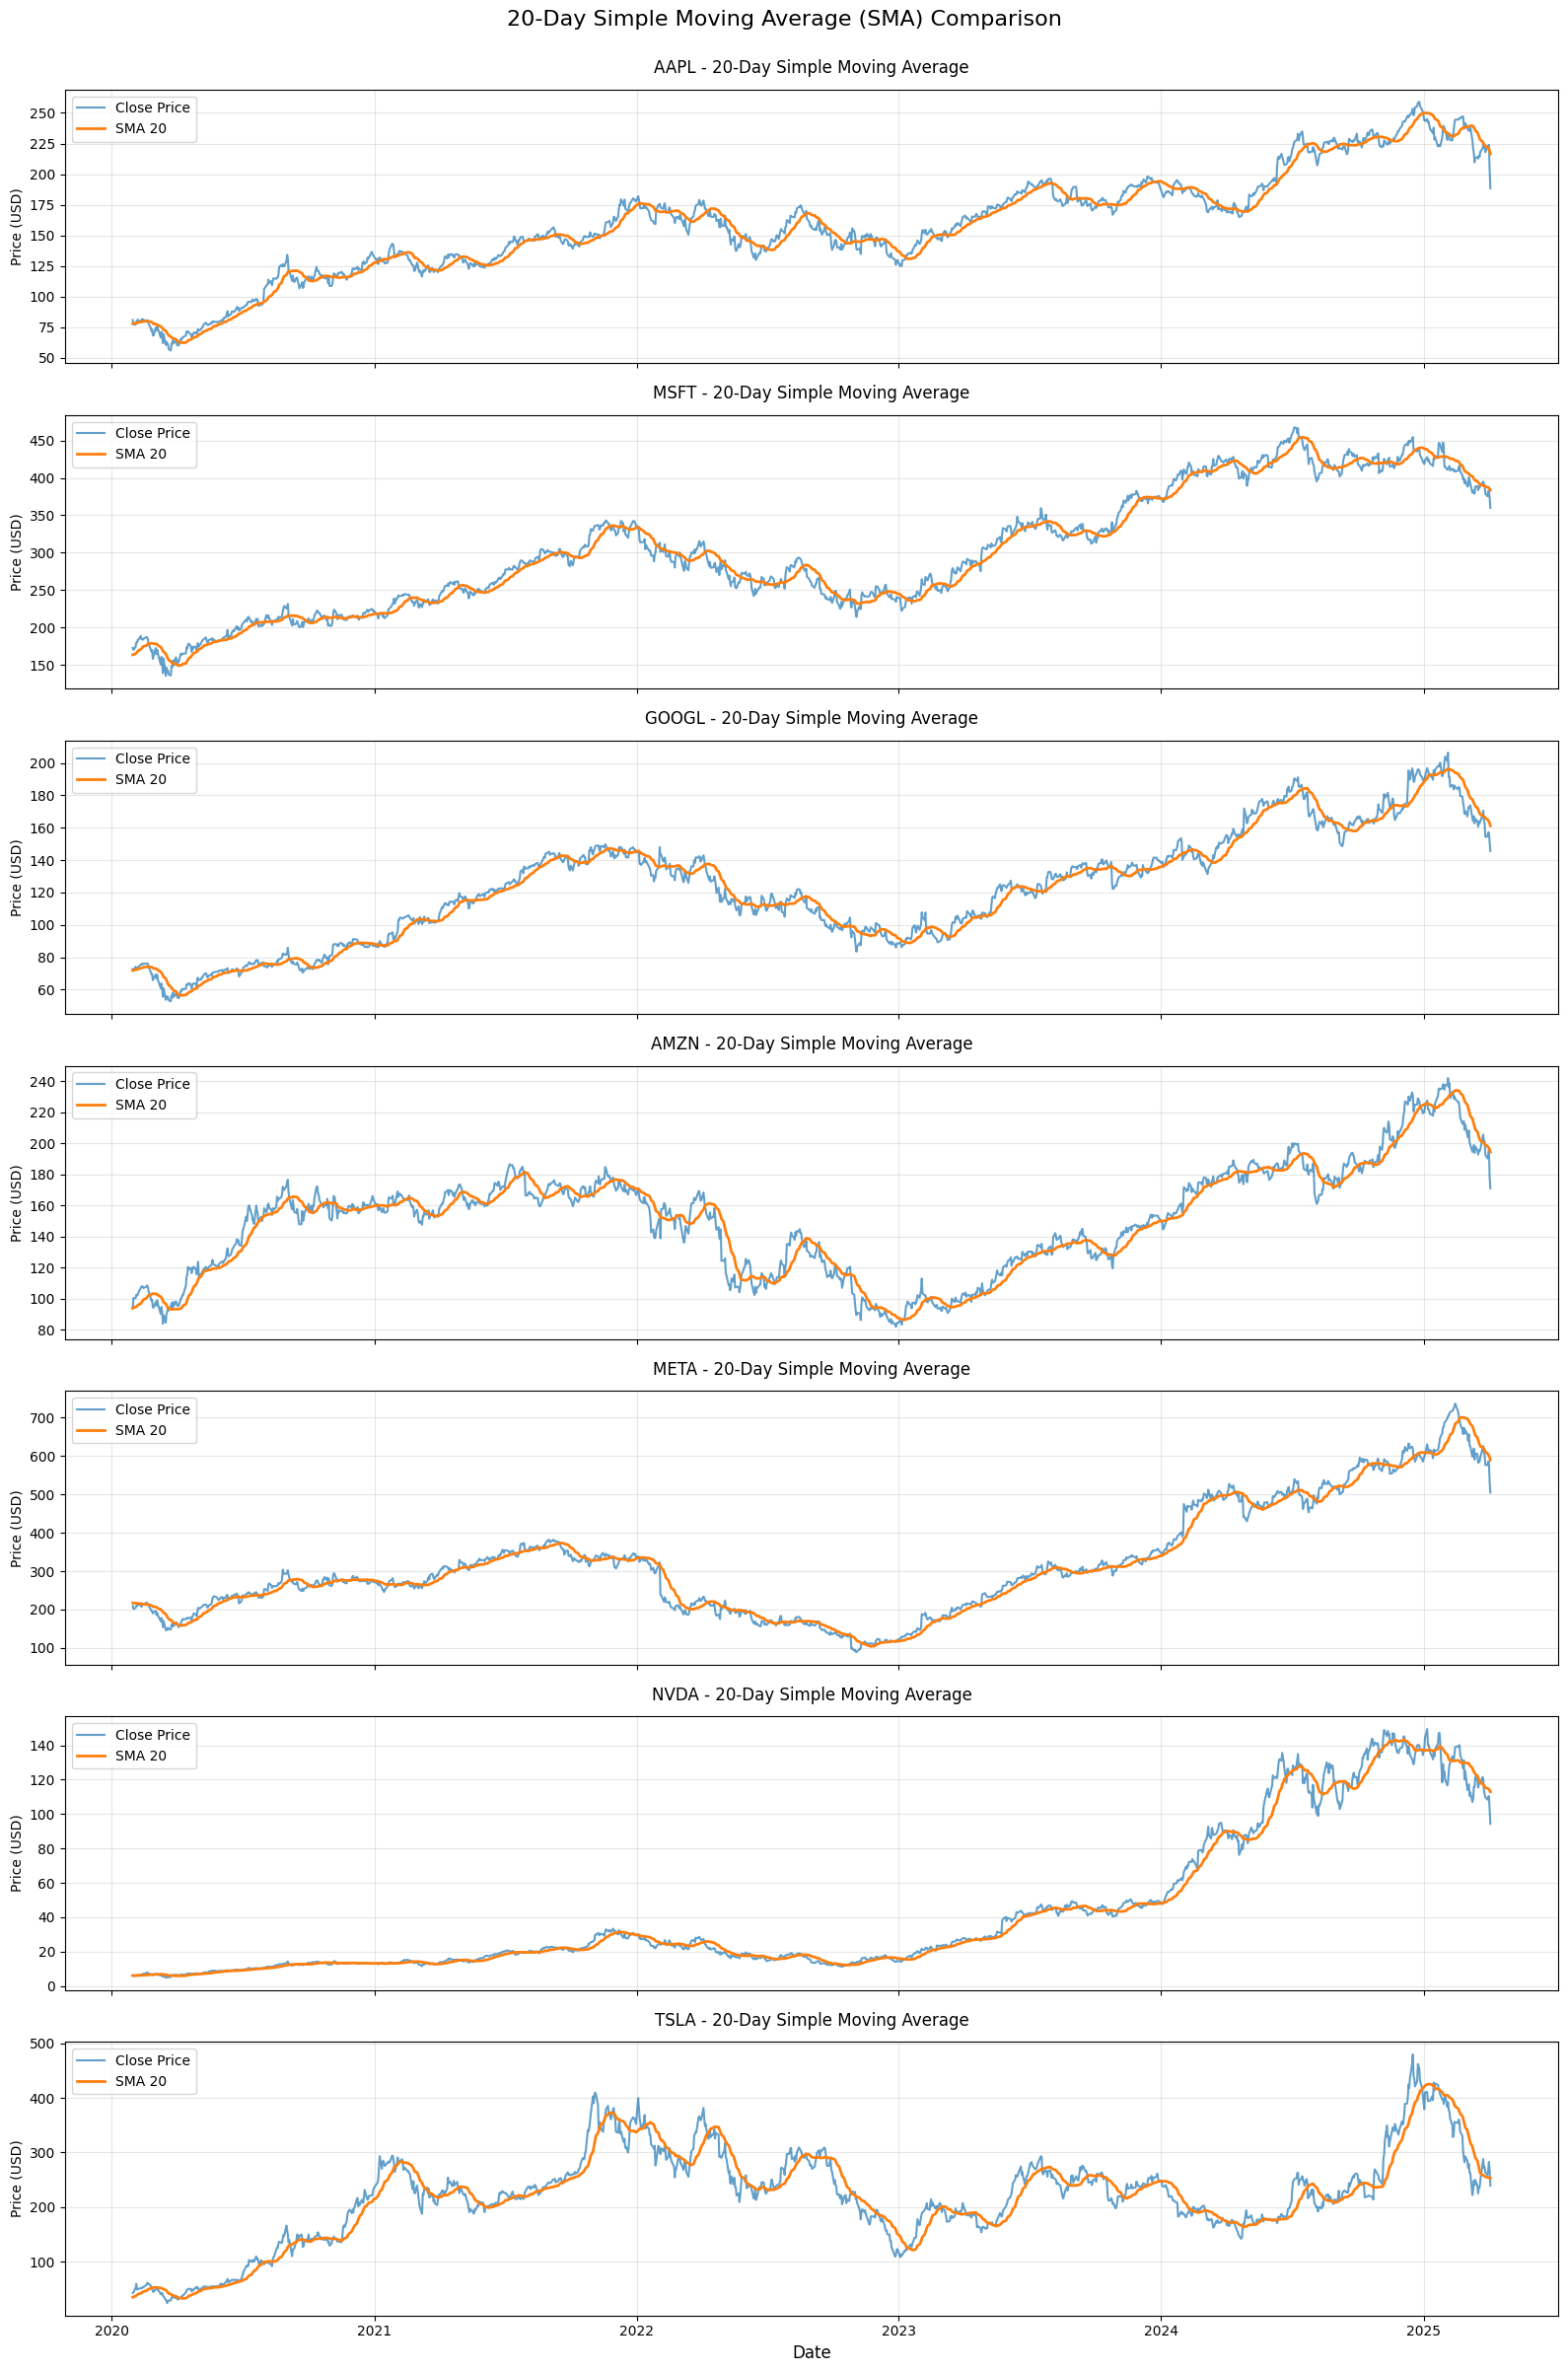

In [9]:

# filter NaNs 
df_viz = df_transformed.dropna(subset=['SMA_20'])

# make subplots
fig, axes = plt.subplots(7, 1, figsize=(16, 24), sharex=True)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

# plot for each ticker (7)
for i, ticker in enumerate(tickers):
    data = df_viz[df_viz['Ticker'] == ticker]
    
    # plot Closing Price and SMA_20
    axes[i].plot(data['Date'], data['Close'], label='Close Price', color='#1f77b4', alpha=0.7)
    axes[i].plot(data['Date'], data['SMA_20'], label='SMA 20', color='#ff7f0e', linewidth=2)
    
    axes[i].set_title(f'{ticker} - 20-Day Simple Moving Average', fontsize=12, pad=12)
    axes[i].set_ylabel('Price (USD)', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper left')

plt.xlabel('Date', fontsize=12)
plt.suptitle('20-Day Simple Moving Average (SMA) Comparison', fontsize=16, y=1)
plt.tight_layout()
plt.show()


